In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

import matplotlib.image as mpimg

import os
import itertools

from models import CycleGAN

- Data Url  
https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [2]:
class CycleDataset(Dataset):
    def __init__(self, file_dir, size):
        self.file_dir = file_dir
        self.file_list = os.listdir(file_dir)
        self.size = size
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def resize2d(self, img):
        with torch.no_grad():
            img = (F.adaptive_avg_pool2d(Variable(img), (self.size, self.size))).data
        return img

    def __getitem__(self, index):
        x = mpimg.imread(self.file_dir + self.file_list[index])
        x = self.transform(x)
        if self.size != 256:
            x = self.resize2d(x)
        return x, 0
 
    def __len__(self):
        return len(self.file_list)

In [3]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [4]:
a_dataset = CycleDataset('data/horse2zebra/trainA/', 128)
b_dataset = CycleDataset('data/horse2zebra/trainA/', 128)

data_A_loader = DataLoader(a_dataset, shuffle=True)
data_B_loader = DataLoader(b_dataset, shuffle=True)

In [5]:
dtype = torch.cuda.FloatTensor

input_ngc = 3
output_ngc = 3
input_ndc = 3
output_ndc = 1
ngf = 32
ndf = 64
nb = 6 #128x128 -> 6 # 256x256 -> 9

In [6]:
G_A = CycleGAN.Generator(input_ngc, output_ngc, ngf, nb, dtype)
G_B = CycleGAN.Generator(input_ngc, output_ngc, ngf, nb, dtype)
D_A = CycleGAN.Discriminator(input_ndc, output_ndc, ndf, dtype)
D_B = CycleGAN.Discriminator(input_ndc, output_ndc, ndf, dtype)

In [7]:
for model in [G_A,G_B,D_A,D_B]:
    model.apply(reset)

In [8]:
G_optimizer = optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
D_A_optimizer = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_B_optimizer = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
lambdaA = 10
labmdaB = 10

trainer = CycleGAN.Trainer(D_A, D_A_optimizer, lambdaA, 
                  D_B, D_B_optimizer, labmdaB,
                  G_A, G_B, G_optimizer, dtype)

raw - fake - rec

Starting 1/10
{'D_A_loss': tensor(0.2206), 'D_B_loss': tensor(0.2559), 'G_A_loss': tensor(0.3944), 'G_B_loss': tensor(0.3554), 'A_cycle_loss': tensor(2.5233), 'B_cycle_loss': tensor(2.7268), 'epoch_time': 185.7843461036682}


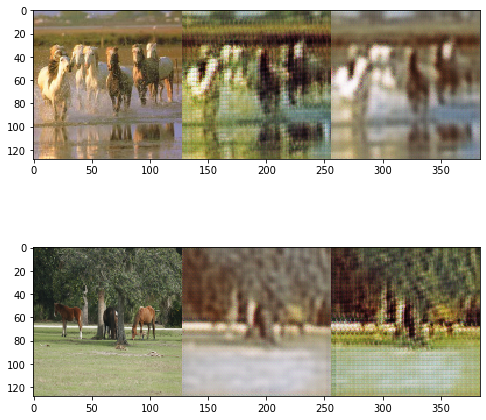

Starting 2/10
{'D_A_loss': tensor(0.1778), 'D_B_loss': tensor(0.2275), 'G_A_loss': tensor(0.3432), 'G_B_loss': tensor(0.3204), 'A_cycle_loss': tensor(2.1605), 'B_cycle_loss': tensor(2.4122), 'epoch_time': 181.99264860153198}


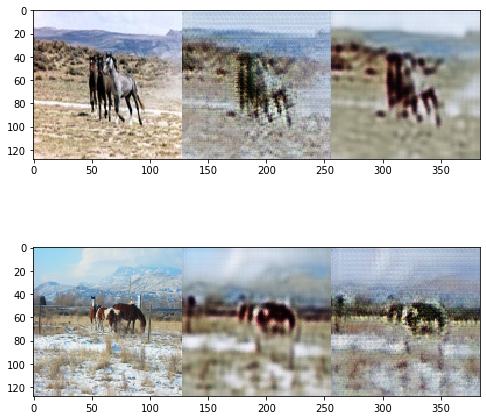

Starting 3/10
{'D_A_loss': tensor(0.1733), 'D_B_loss': tensor(0.2248), 'G_A_loss': tensor(0.3302), 'G_B_loss': tensor(0.3246), 'A_cycle_loss': tensor(2.0108), 'B_cycle_loss': tensor(2.2850), 'epoch_time': 181.69211506843567}


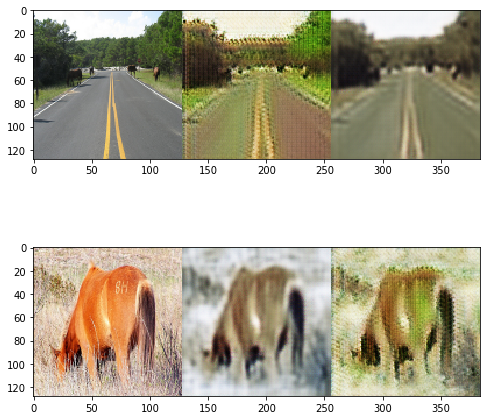

Starting 4/10
{'D_A_loss': tensor(0.1766), 'D_B_loss': tensor(0.2242), 'G_A_loss': tensor(0.3460), 'G_B_loss': tensor(0.3257), 'A_cycle_loss': tensor(1.9390), 'B_cycle_loss': tensor(2.2084), 'epoch_time': 181.00512742996216}


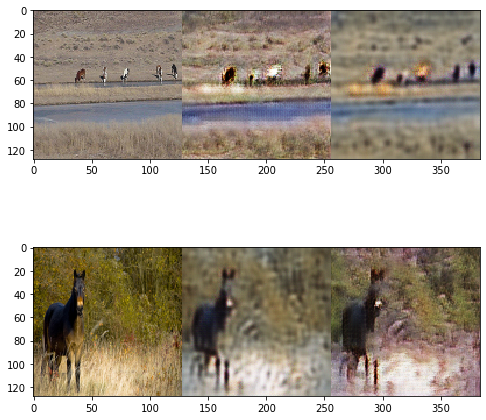

Starting 5/10
{'D_A_loss': tensor(0.1766), 'D_B_loss': tensor(0.2244), 'G_A_loss': tensor(0.3506), 'G_B_loss': tensor(0.3373), 'A_cycle_loss': tensor(1.8746), 'B_cycle_loss': tensor(2.1619), 'epoch_time': 181.07909321784973}


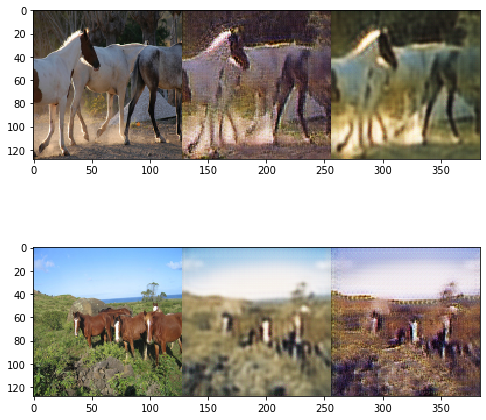

Starting 6/10
{'D_A_loss': tensor(0.1649), 'D_B_loss': tensor(0.2170), 'G_A_loss': tensor(0.3850), 'G_B_loss': tensor(0.3466), 'A_cycle_loss': tensor(1.8327), 'B_cycle_loss': tensor(2.1380), 'epoch_time': 182.51177406311035}


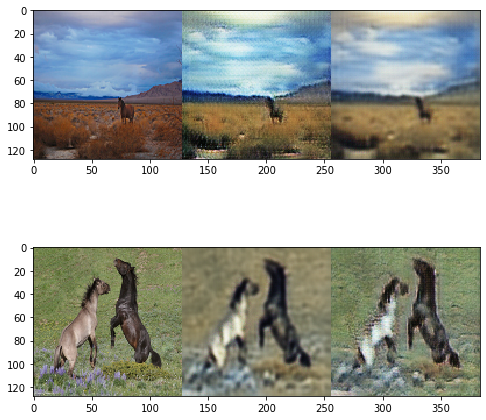

Starting 7/10
{'D_A_loss': tensor(0.1613), 'D_B_loss': tensor(0.2171), 'G_A_loss': tensor(0.4092), 'G_B_loss': tensor(0.3457), 'A_cycle_loss': tensor(1.7884), 'B_cycle_loss': tensor(2.0828), 'epoch_time': 181.47768306732178}


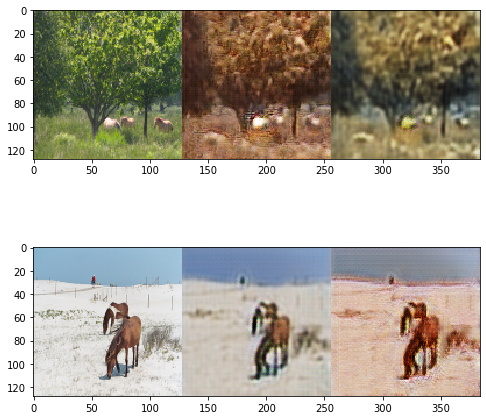

Starting 8/10
{'D_A_loss': tensor(0.1584), 'D_B_loss': tensor(0.2150), 'G_A_loss': tensor(0.3874), 'G_B_loss': tensor(0.3372), 'A_cycle_loss': tensor(1.7622), 'B_cycle_loss': tensor(2.0512), 'epoch_time': 182.99464392662048}


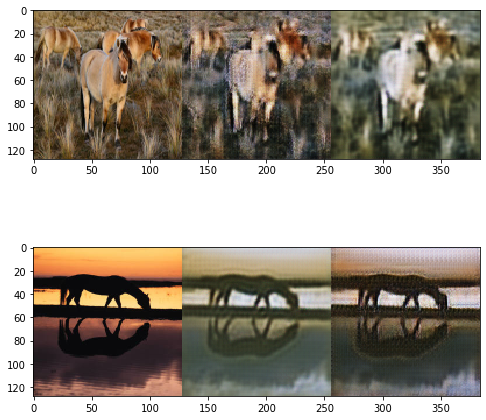

Starting 9/10
{'D_A_loss': tensor(0.1543), 'D_B_loss': tensor(0.2106), 'G_A_loss': tensor(0.3908), 'G_B_loss': tensor(0.3459), 'A_cycle_loss': tensor(1.7217), 'B_cycle_loss': tensor(2.0216), 'epoch_time': 186.0652186870575}


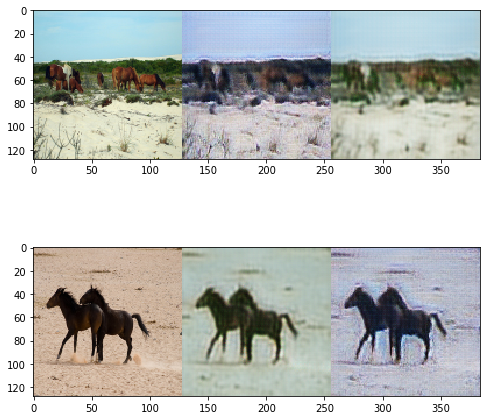

Starting 10/10
{'D_A_loss': tensor(0.1523), 'D_B_loss': tensor(0.2129), 'G_A_loss': tensor(0.4199), 'G_B_loss': tensor(0.3588), 'A_cycle_loss': tensor(1.6969), 'B_cycle_loss': tensor(2.0029), 'epoch_time': 188.3338258266449}


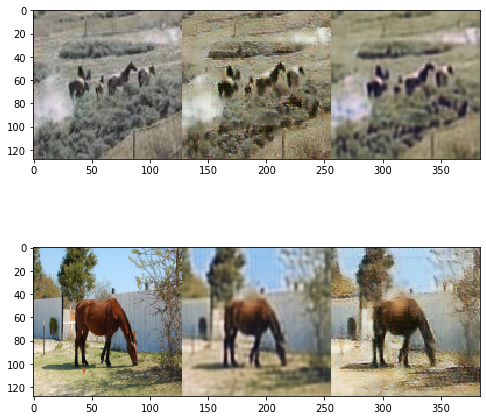

In [10]:
trainer.train(10, data_A_loader, data_B_loader, 1, 1)